In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import os
import cv2

data = []
labels = []
path = "../Data/disaster/"

for folder in os.listdir(path):
    class_path = path + folder + "/"
    for image_path in os.listdir(class_path):
        img = cv2.imread(class_path + image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        labels.append(folder)

In [3]:
import numpy as np

data = np.array(data)
labels = np.array(labels)

In [4]:
from sklearn.preprocessing import LabelBinarizer

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(labels)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=30, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15, 
    horizontal_flip=True, 
    fill_mode="nearest")

In [7]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16

base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

head = base.output
head = Flatten(name="flatten")(head)
head = Dense(512, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(4, activation="softmax")(head)

model = Model(inputs=base.input, outputs=head)

In [9]:
from tensorflow.keras.optimizers import SGD

for layer in base.layers:
    layer.trainable = False

opt = SGD(lr=1e-6, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

h = model.fit_generator(aug.flow(x_train, y_train, batch_size=32), validation_data=(x_test, y_test), 
                        steps_per_epoch=x_train.shape[0] // 32, epochs=30, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 96 steps, validate on 1329 samples
Epoch 1/30
96/96 [==============================] - 86s 900ms/step - loss: 14.0742 - accuracy: 0.3101 - val_loss: 6.1277 - val_accuracy: 0.4492
Epoch 2/30
96/96 [==============================] - 101s 1s/step - loss: 9.9135 - accuracy: 0.3913 - val_loss: 4.2552 - val_accuracy: 0.5816
Epoch 3/30
96/96 [==============================] - 95s 995ms/step - loss: 7.7188 - accuracy: 0.4813 - val_loss: 3.2609 - val_accuracy: 0.6546
Epoch 4/30
96/96 [==============================] - 88s 916ms/step - loss: 6.6633 - accuracy: 0.5259 - val_loss: 2.7011 - val_accuracy: 0.7178
Epoch 5/30
96/96 [==============================] - 86s 895ms/step - loss: 5.8685 - accuracy: 0.5575 - val_loss: 2.3720 - val_accuracy: 0.7532
Epoch 6/30
96/96 [==============================] - 79s 826ms/step - loss: 5.3288 - accuracy: 0.5872 - val_loss: 2.1697 - val_accuracy: 0.77

In [11]:
model.save("../Data/disaster/best.h5")

In [12]:
from sklearn.metrics import classification_report

label_names = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
res = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), res.argmax(axis=1), target_names=label_names))

              precision    recall  f1-score   support

     Cyclone       0.93      0.93      0.93       268
  Earthquake       0.91      0.84      0.87       406
       Flood       0.79      0.79      0.79       321
    Wildfire       0.86      0.93      0.89       334

    accuracy                           0.87      1329
   macro avg       0.87      0.87      0.87      1329
weighted avg       0.87      0.87      0.87      1329



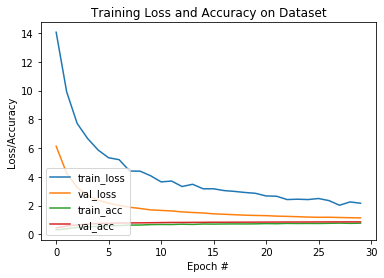

In [14]:
import matplotlib.pyplot as plt

n = np.arange(0, 30)
plt.figure()
plt.plot(n, h.history["loss"], label="train_loss")
plt.plot(n, h.history["val_loss"], label="val_loss")
plt.plot(n, h.history["accuracy"], label="train_acc")
plt.plot(n, h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

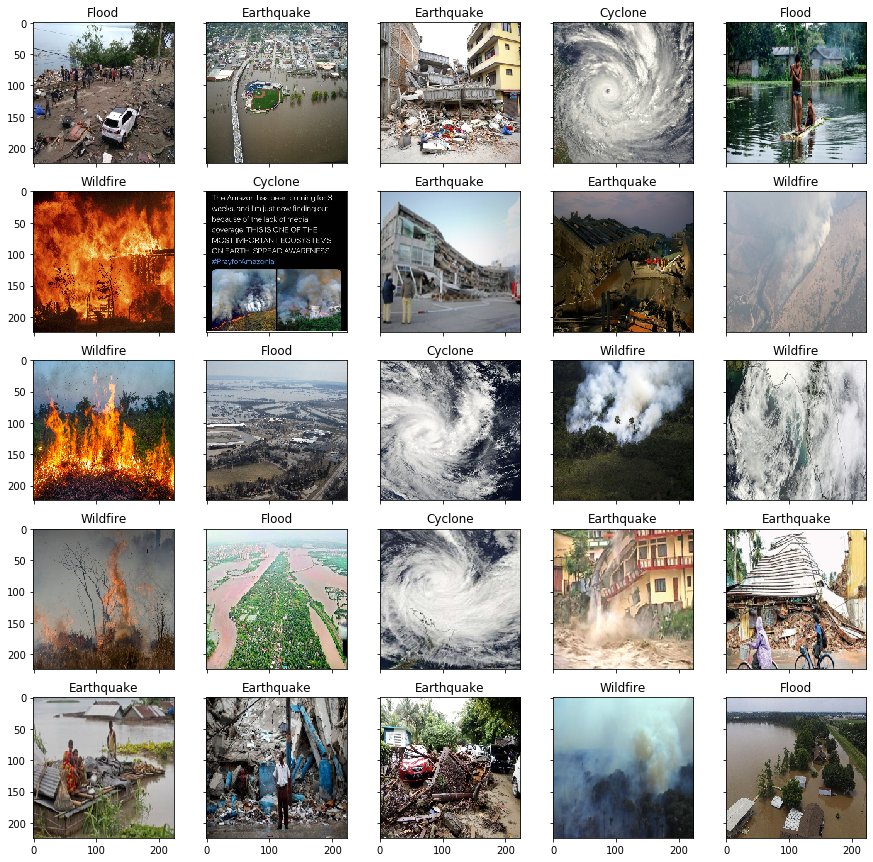

In [15]:
fig, axs = plt.subplots(5, 5)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(5):
    for j in range(5):
        random_num = np.random.randint(0, len(x_test))
        img = x_test[random_num]
        axs[i, j].imshow(img)
        img = img.reshape(1, 224, 224, 3)
        res = model.predict(img)[0]
        axs[i, j].set_title(label_names[res.argmax()])
    
for ax in axs.flat:
    ax.label_outer()